# **Get Data and Preprocess**

In [1]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess(text, string=True):
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if not w in set(stopwords.words("english"))]
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    if string:
        return " ".join(words)
    else:
        return words

In [3]:
def get_data(file):
    data = pd.read_json(file)
    x_data = data['text'].apply(preprocess)
    y_data = data['label']
    return x_data, y_data

In [4]:
import pandas as pd
import numpy as np

In [ ]:
x_train, y_train = get_data('/content/drive/MyDrive/train.json')
x_test, y_test = get_data('/content/drive/MyDrive/test.json')

In [5]:
# x_train.to_csv('data/x_train.csv')
# x_test.to_csv('data/x_test.csv')
x_train = pd.read_csv('x_train.csv', index_col=False, header=0)['text']
x_test = pd.read_csv('x_test.csv', index_col=False, header=0)['text']
x_train

0        bromwell high cartoon comedy ran time program ...
1        homelessness houselessness george carlin state...
2        brilliant overacting lesley ann warren best dr...
3        easily underrated film inn brook cannon sure f...
4        typical mel brook film much le slapstick movie...
                               ...                        
24995    towards end movie felt technical felt like cla...
24996    kind movie enemy content watch time bloody tru...
24997    saw descent last night stockholm film festival...
24998    film pick pound turn rather good 23rd century ...
24999    one dumbest film ive ever seen rip nearly ever...
Name: text, Length: 25000, dtype: object

In [6]:
# y_train.to_csv('data/y_train.csv')
# y_test.to_csv('data/y_test.csv')
y_train = pd.read_csv('y_train.csv', index_col=False, header=0)['label']
y_test = pd.read_csv('y_test.csv', index_col=False, header=0)['label']
y_train.unique()

array(['+', '-'], dtype=object)

In [7]:
mapping = {'+': 1, '-': -1}
train_sentiment = y_train.replace(mapping)
test_sentiment = y_test.replace(mapping)
train_sentiment

0        1
1        1
2        1
3        1
4        1
        ..
24995   -1
24996   -1
24997   -1
24998   -1
24999   -1
Name: label, Length: 25000, dtype: int64

In [8]:
nltk.download('punkt')   
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simyu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
def get_sentences( review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            words = preprocess(raw_sentence, string=False)
            sentences.append(words)
    return sentences

In [ ]:
data = pd.read_json('/content/drive/MyDrive/train.json')
raw_x_train = data['text']
raw_y_train = data['label']
data = pd.read_json('/content/drive/MyDrive/test.json')
raw_x_test = data['text']
raw_y_test = data['label']

In [ ]:
sentences = []
for review in raw_x_train:
    sentences += get_sentences(review, tokenizer)
sentences[0]

In [10]:
# df = pd.DataFrame(np.array(sentences))
# df.reset_index().to_json('/content/drive/MyDrive/sentences.json')
data_sentences = pd.read_json('sentences.json')
sentences = data_sentences['0']
sentences

0                         [bromwell, high, cartoon, comedy]
1               [ran, time, program, school, life, teacher]
2         [35, year, teaching, profession, lead, believe...
3         [scramble, survive, financially, insightful, s...
4         [saw, episode, student, repeatedly, tried, bur...
                                ...                        
270848                [one, dumbest, film, ive, ever, seen]
270849    [rip, nearly, ever, type, thriller, manages, m...
270850    [plot, afterthought, far, acting, go, there, n...
270851    [honestly, cant, understand, type, nonsense, g...
270852    [crap, like, people, downloading, illegally, t...
Name: 0, Length: 270853, dtype: object

In [11]:
all_words = []
for sentence in sentences:
    all_words.extend(sentence)
len(all_words)

vocab = set()
for sentence in sentences:
    vocab.update(sentence)
len(vocab)

111534

# **Feature Engineering with BoW and Tf-idf**

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
def get_bow(clean_train_text, clean_test_text):
    vectorizer = CountVectorizer(analyzer = "word", max_features = 10000) 
    train_bow = vectorizer.fit_transform(clean_train_text).toarray()
    test_bow = vectorizer.transform(clean_test_text).toarray()
    return train_bow, test_bow

In [ ]:
def get_tfidf(train_bow, test_bow):
    tfidf_transformer = TfidfTransformer().fit(train_bow)
    train_tfidf = tfidf_transformer.transform(train_bow)
    test_tfidf = tfidf_transformer.transform(test_bow)
    return train_tfidf, test_tfidf

In [ ]:
train_bow, test_bow = get_bow(x_train.tolist(), x_test.tolist())
train_tfidf, test_tfidf = get_tfidf(train_bow, test_bow)
train_tfidf

# **Feature Engineering with Word2Vec**

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Set values for various parameters
num_features = 500    # Word vector dimensionality
min_word_count = 50   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
word2vec_model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=1)

word2vec_model.init_sims(replace=True)

In [ ]:
def makeFeatureVec(words, model, num_features):
    '''Average all of the word vectors in a paragraph'''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:
def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Given a set of reviews (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
clean_train_reviews = raw_x_train.apply(preprocess, string=False)
clean_test_reviews = raw_x_test.apply(preprocess, string=False)
clean_train_reviews

In [ ]:
# clean_train_reviews.reset_index().to_json('/content/drive/MyDrive/clean_train_reviews.json')
# clean_test_reviews.reset_index().to_json('/content/drive/MyDrive/clean_test_reviews.json')
data_train = pd.read_json('/content/drive/MyDrive/clean_train_reviews.json')
data_test = pd.read_json('/content/drive/MyDrive/clean_test_reviews.json')
clean_train_reviews = data_train['text']
clean_test_reviews = data_test['text']
clean_train_reviews

In [ ]:
train_vectors = getAvgFeatureVecs(clean_train_reviews, word2vec_model, num_features)
test_vectors = getAvgFeatureVecs(clean_test_reviews, word2vec_model, num_features)

In [ ]:
model_name = "/content/drive/MyDrive/500features_50minwords_10context"
# word2vec_model.save(model_name)

In [ ]:
word2vec_model = Word2Vec.load("/content/drive/MyDrive/500features_50minwords_10context")
word_vectors = word2vec_model.wv.syn0

In [ ]:
from sklearn.cluster import KMeans

num_clusters = int(word_vectors.shape[0] / 5)
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
word_centroid_map = dict(zip(word2vec_model.wv.index2word, idx))

In [ ]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    num_centroids = max( word_centroid_map.values() ) + 1
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

In [ ]:
train_centroids = np.zeros( (raw_x_test.size, num_clusters), \
    dtype="float32" )
test_centroids = np.zeros(( raw_y_test.size, num_clusters), \
    dtype="float32" )

In [ ]:
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1
counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# **Pre-Trained Word2Vec**

In [12]:
from gensim.models import KeyedVectors
"/content/drive/MyDrive/500features_50minwords_10context"

embed_lookup = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', 
                                                 binary=True)
pretrained_words = []
for word in embed_lookup.vocab:
    pretrained_words.append(word)

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(all_words)
train_review_lens = Counter([len(x.split()) for x in x_train])
print("Minimum review length: {}".format(min(train_review_lens)))
print("Maximum review length: {}".format(max(train_review_lens)))
test_review_lens = Counter([len(x.split()) for x in x_test])
print("Minimum review length: {}".format(min(test_review_lens)))
print("Maximum review length: {}".format(max(test_review_lens)))
type(counts)

Minimum review length: 4
Maximum review length: 1449
Minimum review length: 3
Maximum review length: 1191


collections.Counter

<BarContainer object of 590 artists>

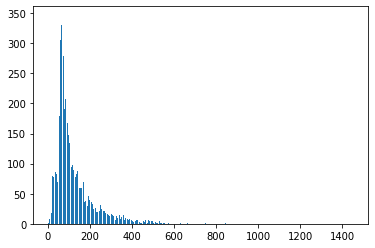

In [14]:
plt.bar(train_review_lens.keys(), train_review_lens.values())

<BarContainer object of 573 artists>

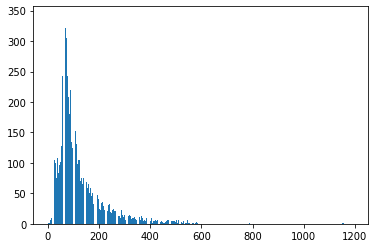

In [15]:
plt.bar(test_review_lens.keys(), test_review_lens.values())

In [16]:
print('Number of training reviews before removing outliers: ', len(x_train))
idx = [ii for ii, review in enumerate(x_train) if (len(review.split()) > 0 and len(review.split()) < 200)]
x_train_no_outliers = [x_train[ii] for ii in idx]
train_sentiment_no_outliers = np.array([train_sentiment[ii] for ii in idx])
print('Number of training reviews after removing outliers: ', len(x_train_no_outliers))

Number of training reviews before removing outliers:  25000
Number of training reviews after removing outliers:  21146


In [17]:
print('Number of testing reviews before removing outliers: ', len(x_test))
idx = [ii for ii, review in enumerate(x_test) if (len(review.split()) > 0 and len(review.split()) < 200)]
x_test_no_outliers = [x_test[ii] for ii in idx]
test_sentiment_no_outliers = np.array([test_sentiment[ii] for ii in idx])
print('Number of testing reviews after removing outliers: ', len(x_test_no_outliers))

Number of testing reviews before removing outliers:  25000
Number of testing reviews after removing outliers:  21373


In [18]:
def tokenize_all_reviews(embed_lookup, reviews):
    reviews_words = [review.split() for review in reviews]
    tokenized_reviews = []
    for review in reviews_words:
        ints = []
        for word in review:
            try:
                idx = embed_lookup.vocab[word].index
            except: 
                idx = 0
            ints.append(idx)
        tokenized_reviews.append(ints)
    
    return tokenized_reviews

In [19]:
tokenized_reviews_train = tokenize_all_reviews(embed_lookup, x_train_no_outliers)
tokenized_reviews_test = tokenize_all_reviews(embed_lookup, x_test_no_outliers)

In [20]:
def pad_features(tokenized_reviews, seq_length):
    features = np.zeros((len(tokenized_reviews), seq_length), dtype=int)
    for i, row in enumerate(tokenized_reviews):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [21]:
seq_length = 200

train_google_features = pad_features(tokenized_reviews_train, seq_length=seq_length)
assert len(train_google_features)==len(tokenized_reviews_train), "Features should have as many rows as reviews."
assert len(train_google_features[0])==seq_length, "Each feature row should contain seq_length values."

test_google_features = pad_features(tokenized_reviews_test, seq_length=seq_length)
assert len(test_google_features)==len(tokenized_reviews_test), "Features should have as many rows as reviews."
assert len(test_google_features[0])==seq_length, "Each feature row should contain seq_length values."

# **Get Metrics and Plots**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score

In [ ]:
def get_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    print('Accuracy:', accuracy)
    f1 = f1_score(y_test, preds)
    print('F1 Score:', f1)

In [ ]:
def get_plot(y_test, preds, title, file):
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('plots/' + file + '.png')
    plt.show()

# **Get Results from models (Naive Bayes)**

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [ ]:
model = GaussianNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with BOW)', 'gaussian_nb_bow')          

In [ ]:
model = GaussianNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with Tf-idf)', 'gaussian_nb_tfidf')        

In [ ]:
model = MultinomialNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with BOW)', 'multinomial_nb_bow')

In [ ]:
model = MultinomialNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with Tf-idf)', 'multinomial_nb_tfidf')

In [ ]:
model = BernoulliNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with BOW)', 'bernoulli_nb_bow')

In [ ]:
model = BernoulliNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())et_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with Tf-idf)', 'bernoulli_nb_tfidf')

In [ ]:
model = BernoulliNB()
model.fit(train_vectors, train_sentiment)
preds = model.predict(test_vectors)
get_metrics(test_sentiment, preds)
# get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with Word2Vec)', 'bernoulli_nb_word2vec')

In [ ]:
model = BernoulliNB()
model.fit(train_centroids, train_sentiment)
preds = model.predict(test_centroids)
get_metrics(test_sentiment, preds)

# **Get Results from models (Decision Trees and Random Forest)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with BOW)', 'decision_tree_bow')

In [ ]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with Tf-idf)', 'decision_tree_tfidf')

In [ ]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with BOW)', 'random_forest_bow')       

In [ ]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with Tf-idf)', 'random_forest_tfidf')        

# **Get Results from models (Linear)**

In [ ]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, SGDOneClassSVM

In [ ]:
model = LogisticRegression(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Logistic Regression (with BOW)', 'logistic_regression_bow')          

In [ ]:
model = LogisticRegression(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Logistic Regression (with Tf-idf)', 'logistic_regression_tfidf')          

In [ ]:
model = LogisticRegression(random_state=4248, max_iter=4248)
model.fit(train_centroids, train_sentiment)
preds = model.predict(test_centroids)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Logistic Regression (with Centroids)', 'logistic_regression_centroids') 

In [ ]:
model = PassiveAggressiveClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Passive Agressive (with BOW)', 'passive_aggressive_bow')  

In [ ]:
model = PassiveAggressiveClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Passive Agressive (with Tf-idf)', 'passive_aggressive_tfidf') 

In [ ]:
model = Perceptron(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Perceptron (with BOW)', 'perceptron_bow')  

In [ ]:
model = Perceptron(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Perceptron (with Tf-idf)', 'perceptron_tfidf') 

In [ ]:
model = RidgeClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Ridge Classifier (with BOW)', 'ridge_classifier_bow')  

In [ ]:
model = RidgeClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Ridge Classifier (with Tf-idf)', 'ridge_classifier_tfidf') 

In [ ]:
model = SGDClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'SGD Classifier (with BOW)', 'sgd_classifier_bow')  

In [ ]:
model = SGDClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'SGD Classifier (with Tf-idf)', 'sgd_classifier_tfidf') 

# **Get Results from models (NN)**

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(random_state=4248, max_iter=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multi-layer Perceptron (with BOW)', 'multi_layer_perceptron_bow')          

In [ ]:
model = MLPClassifier(random_state=4248, max_iter=4248)
model.fit(train_tfidf, train_sentiment)
preds = model.predict(test_tfidf)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multi-layer Perceptron (with Tf-idf)', 'multi_layer_perceptron_tfidf')

In [22]:
from sklearn.model_selection import train_test_split
train_google_features, val_google_features, train_sentiment_no_outliers, val_sentiment_no_outliers = train_test_split(
                                          train_google_features, train_sentiment_no_outliers, test_size=0.2, random_state=4248)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.cuda.empty_cache()

train_data = TensorDataset(torch.from_numpy(train_google_features), torch.from_numpy(train_sentiment_no_outliers))
val_data = TensorDataset(torch.from_numpy(val_google_features), torch.from_numpy(val_sentiment_no_outliers))
test_data = TensorDataset(torch.from_numpy(test_google_features), torch.from_numpy(test_sentiment_no_outliers))

batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentCNN(nn.Module):
    def __init__(self, embed_model, vocab_size, output_size, embedding_dim,
                 num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True, drop_prob=0.5):
        super(SentimentCNN, self).__init__()
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
        
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2,0)) 
            for k in kernel_sizes])
        
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size) 
        self.dropout = nn.Dropout(drop_prob)
        self.sig = nn.Sigmoid()
        
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        embeds = self.embedding(x) 
        embeds = embeds.unsqueeze(1)
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)
        logit = self.fc(x) 
        return self.sig(logit)

In [25]:
vocab_size = len(pretrained_words)
output_size = 1 
embedding_dim = len(embed_lookup[pretrained_words[0]]) 
num_filters = 100
kernel_sizes = [3, 4, 5]

net = SentimentCNN(embed_lookup, vocab_size, output_size, embedding_dim,
                   num_filters, kernel_sizes)
net

SentimentCNN(
  (embedding): Embedding(299567, 300)
  (convs_1d): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1), padding=(3, 0))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig): Sigmoid()
)

In [27]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [28]:
def train(net, train_loader, epochs, print_every=100):
    net.cuda()
    counter = 0 
    net.train()

    for e in range(epochs):
        for inputs, labels in train_loader:
            counter += 1
            inputs, labels = inputs.cuda(), labels.cuda()
            net.zero_grad()
            output = net(inputs)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            if counter % print_every == 0:
                val_losses = []
                net.eval()

                for inputs, labels in val_loader:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    output = net(inputs)
                    val_loss = criterion(output.squeeze(), labels.float())
                    val_losses.append(val_loss.item())
                    
                net.train()
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [29]:
epochs = 4
print_every = 100
train(net, train_loader, epochs, print_every=print_every)

Epoch: 1/4... Step: 100... Loss: -8.504826... Val Loss: -6.437160
Epoch: 1/4... Step: 200... Loss: -11.942618... Val Loss: -13.192592
Epoch: 1/4... Step: 300... Loss: -17.428617... Val Loss: -13.438613
Epoch: 2/4... Step: 400... Loss: -20.868086... Val Loss: -16.135319
Epoch: 2/4... Step: 500... Loss: -18.252964... Val Loss: -17.130573
Epoch: 2/4... Step: 600... Loss: -11.983171... Val Loss: -19.740012
Epoch: 3/4... Step: 700... Loss: -29.794590... Val Loss: -18.037897
Epoch: 3/4... Step: 800... Loss: -31.435034... Val Loss: -19.954795
Epoch: 3/4... Step: 900... Loss: -26.271376... Val Loss: -21.188526
Epoch: 3/4... Step: 1000... Loss: -39.483852... Val Loss: -21.129618
Epoch: 4/4... Step: 1100... Loss: -26.058353... Val Loss: -21.361769
Epoch: 4/4... Step: 1200... Loss: -33.342266... Val Loss: -22.228879
Epoch: 4/4... Step: 1300... Loss: -39.331150... Val Loss: -24.081287


In [31]:
test_losses = []
num_correct = 0
net.eval()

for inputs, labels in test_loader:
    inputs, labels = inputs.cuda(), labels.cuda()
    output = net(inputs)
    
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())
    
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: -23.835
Test accuracy: 0.311


# **Artificial Movie Review Generation**